In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.pipeline import FeatureUnion

from scipy.sparse import hstack

import warnings

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/webinar_3/train_case2_preproc_ap.csv', ';')
print(df.shape)
df.head()

(69940, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.set_index('id', inplace=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), df['cardio'], random_state=0)

К полям:
- gender, cholesterol, gluc применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol', 'gluc']
base_cols = ['smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-0.17815477,  0.08192277, -0.63596288, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95535267,  0.56905749,  0.26711895, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.95494799, -0.6487793 ,  1.30913644, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.0022955 ,  0.44727381,  1.23966861, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.65143832, -1.01413034, -0.14968805, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.55832521, -0.52699562, -0.77489855, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию "LogisticRegression"

In [28]:
lr_classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(lr_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
lr_classifier.fit(X_train, y_train)
y_score_lr = lr_classifier.predict_proba(X_test)[:, 1]

CV score is 0.795339365892823+-0.005553170062436372


Посчитаем precision/recall/f_score

In [29]:
b=1
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test.values, y_score_lr)
fscore_lr = (1+b**2)*(precision_lr * recall_lr) / (b**2*precision_lr + recall_lr)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_lr[ix_lr], 
                                                                        fscore_lr[ix_lr],
                                                                        precision_lr[ix_lr],
                                                                        recall_lr[ix_lr]))

Best Threshold=0.405643, F-Score=0.737, Precision=0.684, Recall=0.799


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

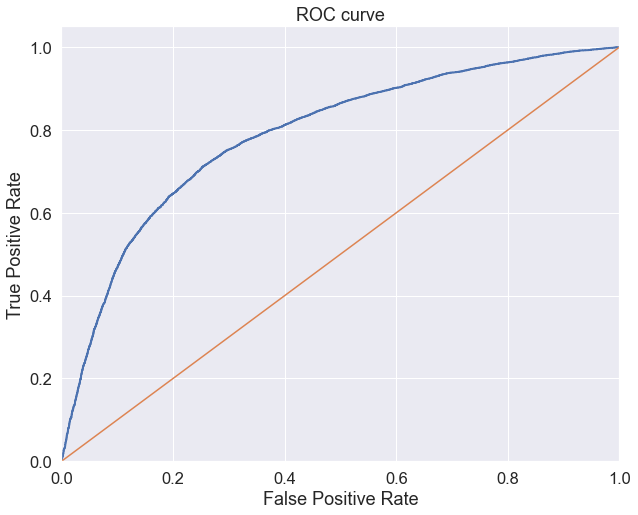

In [30]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score_lr, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# plt.savefig("ROC.png")
plt.show()

In [32]:
roc_auc_lr = roc_auc_score(y_true=y_test, y_score=lr_classifier.predict_proba(X_test)[:,1])
log_loss_lr = log_loss(y_true=y_test, y_pred=lr_classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_lr))
print("log loss score: {}".format(log_loss_lr))

roc auc score: 0.7883118811190726
log loss score: 0.5643077984171904


Посмотрим на матрицу ошибок

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5477 3237]
 [1766 7005]]


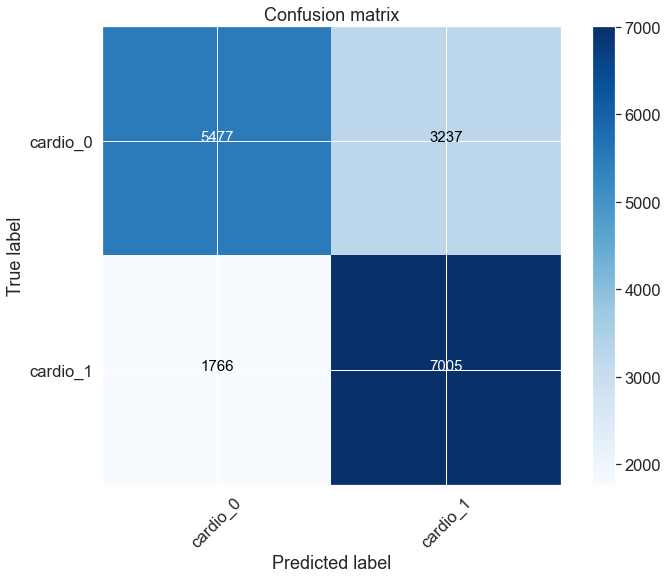

In [50]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, y_score_lr>thresholds_lr[ix_lr])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_lr, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [51]:
TN = cnf_matrix_lr[0][0]
FN = cnf_matrix_lr[1][0]
TP = cnf_matrix_lr[1][1]
FP = cnf_matrix_lr[0][1]

TPR_lr = TP/(TP+FN)
FPR_lr = FP/(FP+TN)
TNR_lr = TN/(FP+TN)
TPR_lr, FPR_lr, TNR_lr

(0.7986546573936837, 0.37147119577691073, 0.6285288042230893)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Найдём лучшие гиперпараметры "RandomForestClassifier":

In [14]:
rf_classifier = GridSearchCV(RandomForestClassifier(random_state = 42), {
    'n_estimators': [100, 120, 140], # best - 100, 140
    'min_samples_leaf': [8, 10], # best - 8
    'max_depth': [14, 16], # best - 14
}, cv=4, n_jobs=6, return_train_score=True)

rf_classifier.fit(feature_processing.fit_transform(X_train), y_train)

temp_df = pd.DataFrame(rf_classifier.cv_results_)

In [15]:
temp_df.loc[temp_df['mean_test_score'] > 0.736, ['param_n_estimators', 'param_min_samples_leaf', 'param_max_depth', 'mean_train_score', 'mean_test_score']].sort_values(['param_n_estimators', 'param_min_samples_leaf', 'param_max_depth'], ascending=False)

,param_n_estimators,param_min_samples_leaf,param_max_depth,mean_train_score,mean_test_score
11,140,10,16,0.766498,0.736060
5,140,10,14,0.762895,0.737013
2,140,8,14,0.766530,0.737356
10,120,10,16,0.766435,0.736365
4,120,10,14,0.763035,0.737108
7,120,8,16,0.771582,0.736002
1,120,8,14,0.766282,0.737184
9,100,10,16,0.766555,0.736174
3,100,10,14,0.762813,0.737127
6,100,8,16,0.771252,0.736345


Найдём лучшие гиперпараметры "GradientBoostingClassifier":

In [18]:
gb_classifier = GridSearchCV(GradientBoostingClassifier(random_state = 42), {
    'n_estimators': [100, 120, 140, 160], # best - 120
    'min_samples_leaf': [4, 6, 8], # best - 6
    'max_depth': [2, 4, 6], # best - 4
}, cv=4, n_jobs=6, return_train_score=True)

gb_classifier.fit(feature_processing.fit_transform(X_train), y_train)

temp_df = pd.DataFrame(gb_classifier.cv_results_)

In [19]:
temp_df.loc[temp_df['mean_test_score'] > 0.736, ['param_n_estimators', 'param_min_samples_leaf', 'param_max_depth', 'mean_train_score', 'mean_test_score']].sort_values(['param_n_estimators', 'param_min_samples_leaf', 'param_max_depth'], ascending=False)

,param_n_estimators,param_min_samples_leaf,param_max_depth,mean_train_score,mean_test_score
35,160,8,6,0.767204,0.736002
23,160,8,4,0.748801,0.737127
11,160,8,2,0.739065,0.736136
19,160,6,4,0.748909,0.737489
7,160,6,2,0.738944,0.736193
15,160,4,4,0.749334,0.737451
3,160,4,2,0.738951,0.736193
22,140,8,4,0.747587,0.737127
10,140,8,2,0.738595,0.736059
18,140,6,4,0.747720,0.737585


Добавим классификатор и запустим кросс-валидацию для "RandomForestClassifier"

In [36]:
rf_classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100, min_samples_leaf=8, max_depth=14, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
rf_classifier.fit(X_train, y_train)
y_score_rf = rf_classifier.predict_proba(X_test)[:, 1]

CV score is 0.8037803354204351+-0.00640992008281072


Посчитаем precision/recall/f_score

In [37]:
b=1
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_rf)
fscore_rf = (1+b**2)*(precision_rf * recall_rf) / (b**2*precision_rf + recall_rf)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

Best Threshold=0.390092, F-Score=0.743, Precision=0.689, Recall=0.805


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

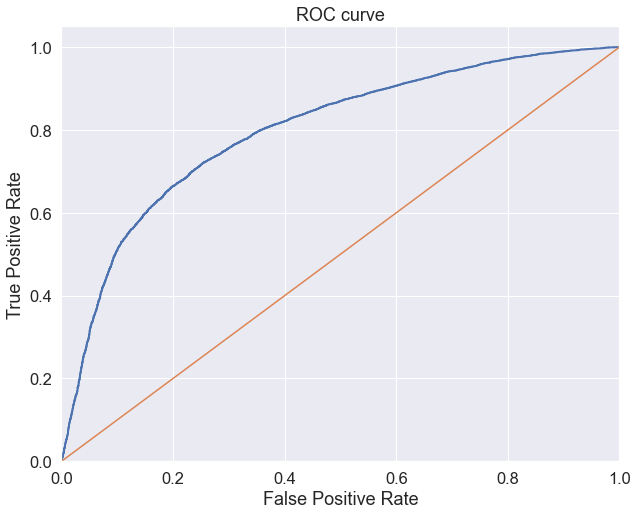

In [38]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score_rf, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# plt.savefig("ROC.png")
plt.show()

In [39]:
roc_auc_rf = roc_auc_score(y_true=y_test, y_score=rf_classifier.predict_proba(X_test)[:,1])
log_loss_rf = log_loss(y_true=y_test, y_pred=rf_classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_rf))
print("log loss score: {}".format(log_loss_rf))

roc auc score: 0.7980142781754098
log loss score: 0.5446239520111075


Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[5529 3185]
 [1710 7061]]


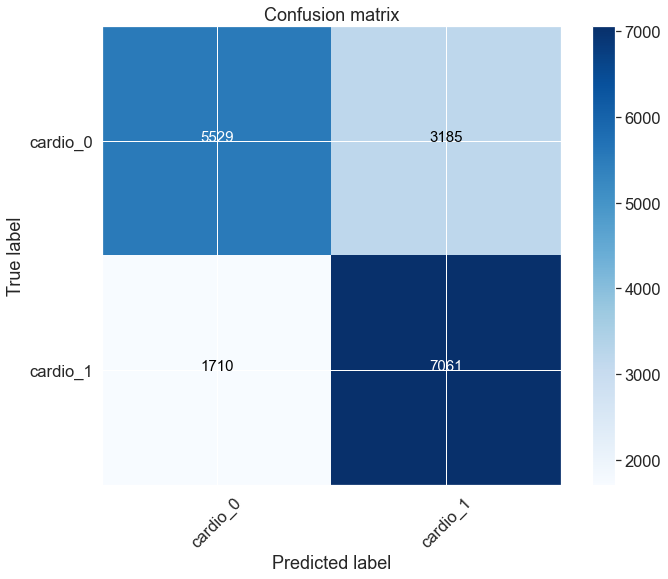

In [47]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, y_score_rf>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [48]:
TN = cnf_matrix_rf[0][0]
FN = cnf_matrix_rf[1][0]
TP = cnf_matrix_rf[1][1]
FP = cnf_matrix_rf[0][1]

TPR_rf = TP/(TP+FN)
FPR_rf = FP/(FP+TN)
TNR_rf = TN/(FP+TN)
TPR_rf, FPR_rf, TNR_rf

(0.805039334169422, 0.36550378700941016, 0.6344962129905899)

Добавим классификатор и запустим кросс-валидацию для "GradientBoostingClassifier"

In [40]:
gb_classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators=120, min_samples_leaf=6, max_depth=4, random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(gb_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
gb_classifier.fit(X_train, y_train)
y_score_gb = gb_classifier.predict_proba(X_test)[:, 1]

CV score is 0.8050346334394657+-0.0058699715075345


Посчитаем precision/recall/f_score

In [41]:
b=1
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test.values, y_score_gb)
fscore_gb = (1+b**2)*(precision_gb * recall_gb) / (b**2*precision_gb + recall_gb)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

Best Threshold=0.391319, F-Score=0.742, Precision=0.697, Recall=0.795


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

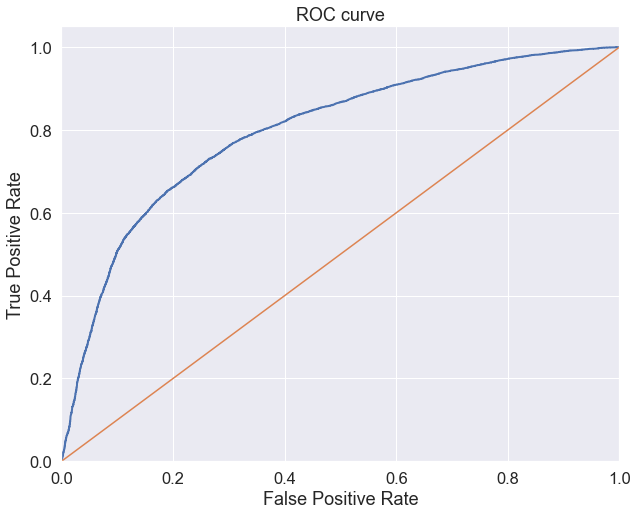

In [42]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score_gb, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
# plt.savefig("ROC.png")
plt.show()

In [43]:
roc_auc_gb = roc_auc_score(y_true=y_test, y_score=gb_classifier.predict_proba(X_test)[:,1])
log_loss_gb = log_loss(y_true=y_test, y_pred=gb_classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(roc_auc_gb))
print("log loss score: {}".format(log_loss_gb))

roc auc score: 0.7980626947144944
log loss score: 0.5444086821728349


Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[5198 3516]
 [1632 7139]]


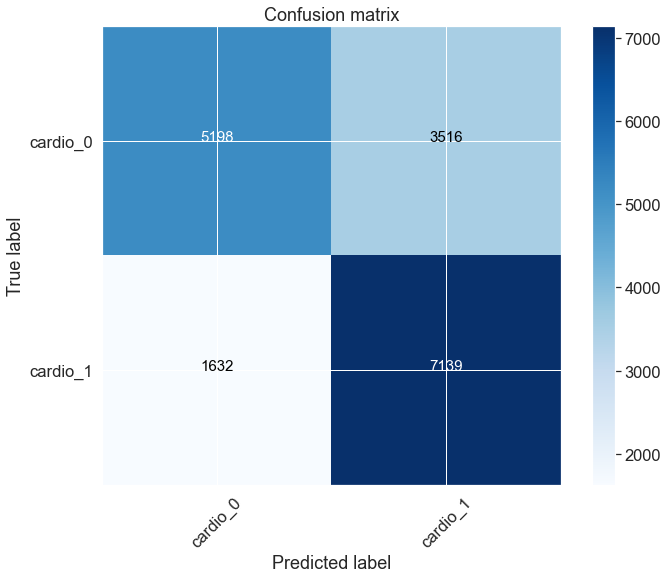

In [52]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, y_score_lr>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

Посчитаем FPR, TPR

In [53]:
TN = cnf_matrix_gb[0][0]
FN = cnf_matrix_gb[1][0]
TP = cnf_matrix_gb[1][1]
FP = cnf_matrix_gb[0][1]

TPR_gb = TP/(TP+FN)
FPR_gb = FP/(FP+TN)
TNR_gb = TN/(FP+TN)
TPR_gb, FPR_gb, TNR_gb

(0.8139322768213431, 0.40348863897176956, 0.5965113610282304)

In [54]:
score_dct = {
    'roc_auc': [roc_auc_lr, roc_auc_rf, roc_auc_gb],
    'precision': [precision_lr[ix_lr], precision_rf[ix_rf], precision_gb[ix_gb]],
    'recall': [recall_lr[ix_lr], recall_rf[ix_rf], recall_gb[ix_gb]],
    'f_score': [fscore_lr[ix_lr], fscore_rf[ix_rf], fscore_gb[ix_gb]],
    'log_loss': [log_loss_lr, log_loss_rf, log_loss_gb],
    'TPR': [TPR_lr, TPR_rf, TPR_gb],
    'FPR': [FPR_lr, FPR_rf, FPR_gb],
}

pd.DataFrame(data=score_dct, index=['for_logreg', 'for_randomforest', 'for_gradientbusting'])

,roc_auc,precision,recall,f_score,log_loss,TPR,FPR
for_logreg,0.788312,0.683979,0.798769,0.736931,0.564308,0.798655,0.371471
for_randomforest,0.798014,0.689177,0.805153,0.742665,0.544624,0.805039,0.365504
for_gradientbusting,0.798063,0.696621,0.794550,0.742370,0.544409,0.813932,0.403489


Выводы:

1 Результаты моделей очень близки, но лучшие результаты показала RandomForest-модель, как имеющая наибольший TPR и наименьший FPR.

2 (ответ на вопрос № 5) В случае сильного дисбаланса классов (с учётом рассмотренного примера), лучше всего подходит Precision-Recall-curve.
Так ROC-AUC-score для обеих моделей показывает крайне близкое значение (т.к. TPR=0.9, FPR~0.0001) - 0.94995 с точностью до пятого знака после запятой, то выбрать лучшую модель затруднительно.
При этом для первой модели Precision=0.9, Recall=0.9 (F-score=0.9), а для второй Precision=0.09, Recall=0.9 (F-score=0.1(63)), т.е. очевидно, что первая модель предпочтительна.